In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

import iisignature
from tqdm import tqdm

In [2]:
def shift_stim(stims : pd.Series, shift : int):
    # shifts all stimuli by an amount
    stims[stims != 0] += shift
    return stims

In [3]:
def load_subject(data_paths, col='emg'):
    df = pd.DataFrame([])
    tot_stim = 0
    for i, data_path in enumerate(data_paths):
        mat = sio.loadmat(data_path)
        if i == 0:
            df = pd.DataFrame(mat[col])
            df['stimulus'] = mat['restimulus']
            df['repetition'] = mat['rerepetition']
        else:
            df2 = pd.DataFrame(mat[col])
            df2['stimulus'] = shift_stim(pd.DataFrame(mat['restimulus']), tot_stim)
            df2['repetition'] = mat['rerepetition']
            df = pd.concat([df, df2], ignore_index=True)
        tot_stim += len(np.unique(mat['restimulus'])) - 1
    return df

In [4]:
#exercises = [1, 2, 3]
exercises = [1]
databases = ['db5', 'db1']
root = './signatures_data/'
df = pd.DataFrame([])
for database in databases:
    if database == 'db5':
        subjects = range(1, 11)
    elif database == 'db1':
        subjects = range(11, 38)
    
    for subject in subjects:
        if database == 'db5':
            data_paths = [os.path.join(root, f"{database}/s{subject}/S{subject}_E{exercise}_A1.mat") for exercise in exercises]
        elif database == 'db1':
            data_paths = [os.path.join(root, f"{database}/S{subject-10}_A1_E{exercise}.mat") for exercise in exercises]
        cur_df = load_subject(data_paths, col='glove')
        cur_df['subject'] = subject
        df = pd.concat([df, cur_df], ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,stimulus,repetition,subject
0,81.193825,-25.613001,17.336512,-6.904053,12.986491,18.831488,1.902927,19.194145,6.613120,-22.310045,...,27.264063,21.547808,-0.084706,13.291741,65.754509,2.470584,24.564764,0,1,1
1,81.147217,-25.613001,17.336512,-6.949311,12.898676,18.659233,1.944808,19.242105,6.309145,-22.280998,...,27.264063,21.477554,-0.084706,13.291741,65.754509,2.470584,24.564764,0,1,1
2,81.100609,-25.613001,17.336512,-6.994570,12.810861,18.486980,1.986689,19.290066,6.005171,-22.251951,...,27.264063,21.407303,-0.084706,13.291741,65.754509,2.470584,24.564764,0,1,1
3,81.054001,-25.613001,17.336512,-7.039829,12.723045,18.314728,2.028570,19.338028,5.701196,-22.222904,...,27.264063,21.337051,-0.084706,13.291741,65.754509,2.470584,24.564764,0,1,1
4,81.007385,-25.613001,17.336512,-7.085087,12.635230,18.142475,2.070451,19.385988,5.397222,-22.193857,...,27.264063,21.266798,-0.084706,13.291741,65.754509,2.470584,24.564764,0,1,1


In [5]:
df.shape

(4190423, 25)

In [6]:
np.unique(df['stimulus'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int16)

In [7]:
np.unique(df['repetition'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int16)

Original DB5 paper utilizes repetitions 1, 3, 4, 5 for training classifiers and repetitions 2, 5 for validation

In [8]:
train_set = [1, 3, 4, 6]
test_set = [2, 5]

In [9]:
def compute_log_signature(path, depth, dims=None):
    if dims is None:
        dims = path.shape[1] # take second, assumes (timesteps, dims)
    s = iisignature.prepare(dims, depth)
    return iisignature.logsig(path, s)

We define a few utilities for dealing with the Ninapro data: a normalizer, which takes sEMG data and specific repetitions, then centers and scales those repetitions to unit variance as well as the notion of a path, which can be windowed to a specified size and designated overlap between successive windows.

In [10]:
from normalizers import *
from paths import *

In [11]:
def splitxy(dfs : list, x_cols, y_col):
    x = []
    y = []
    for df in dfs:
        x.append(df[x_cols].to_numpy())
        y.append(df[y_col].to_numpy()[0]) # assume everything is of the same class
    return np.array(x), np.array(y).reshape(-1)

We use a SVM since it's not immediately apparent what to do with such high-dimensional data. The human action recognition example used a linear classifier with a dropout layer, which was trained.

In [12]:
def accuracy(pred, true):
    assert len(pred) == len(true), "check lengths match"
    return np.sum((pred == true)) / len(pred)


In [13]:
assert accuracy(np.array([1, 1, 1, 2]), np.array([1, 2, 1, 2])) == 0.75

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Try the same thing with glove data!

Let's stick to differentiating between stimuli $1$ and $3$ - pretty sure there should be some significant differences here. Let's look at glove data plots.

Let's look at just subject $1$, exercise $1$ vs exercise $3$'s activity so we can extract out what we think are relevant features.

In [15]:
root = './signatures_data/'
from paths import *
from normalizers import *

In [16]:
#data_paths = [os.path.join(root, f"s1/S1_E{exercise}_A1.mat") for exercise in exercises]
data_paths = [os.path.join(root, f"db5/s1/S1_E1_A1.mat")]
s1_df = load_subject(data_paths, col='glove')

<AxesSubplot: title={'center': 'Glove Electrode Signals, subject 1, exercise 1'}>

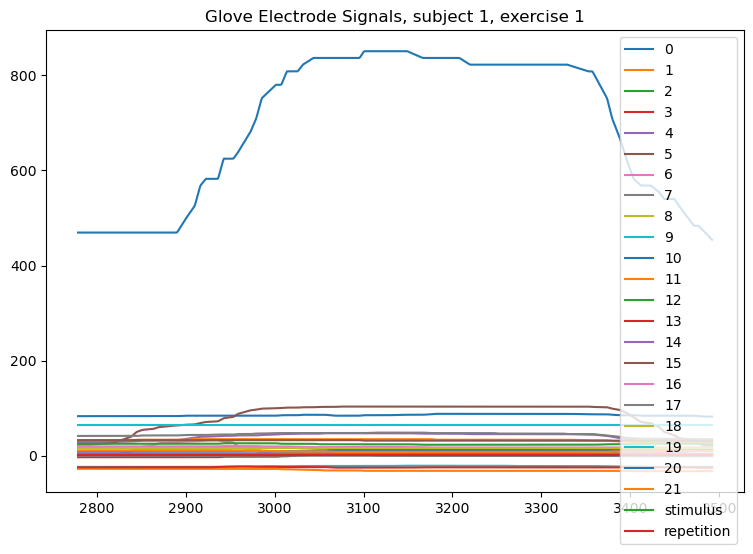

In [17]:
s1_df[(s1_df.stimulus==1) & (s1_df.repetition==2)].plot(figsize=(9,6), title="Glove Electrode Signals, subject 1, exercise 1")

<AxesSubplot: title={'center': 'Glove Electrode Signals, subject 1, exercise 3'}>

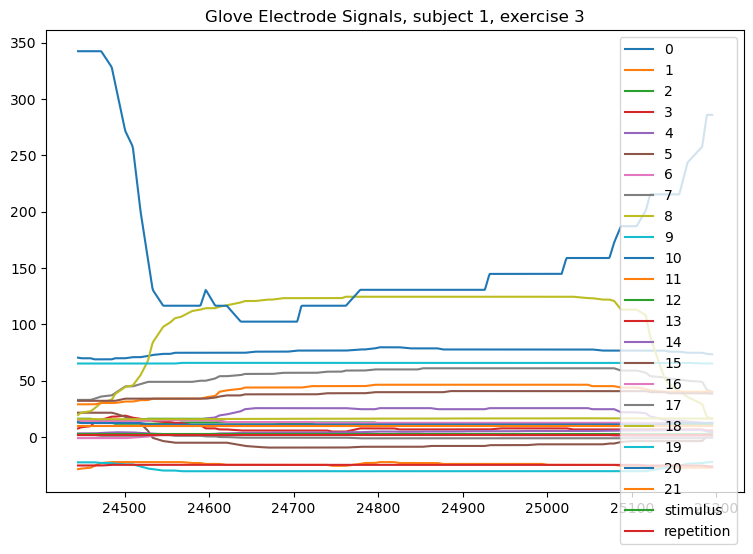

In [18]:
s1_df[(s1_df.stimulus==3) & (s1_df.repetition==2)].plot(figsize=(9,6), title="Glove Electrode Signals, subject 1, exercise 3")

<AxesSubplot: title={'center': 'Glove Electrode Signals, subject 1, exercise 5'}>

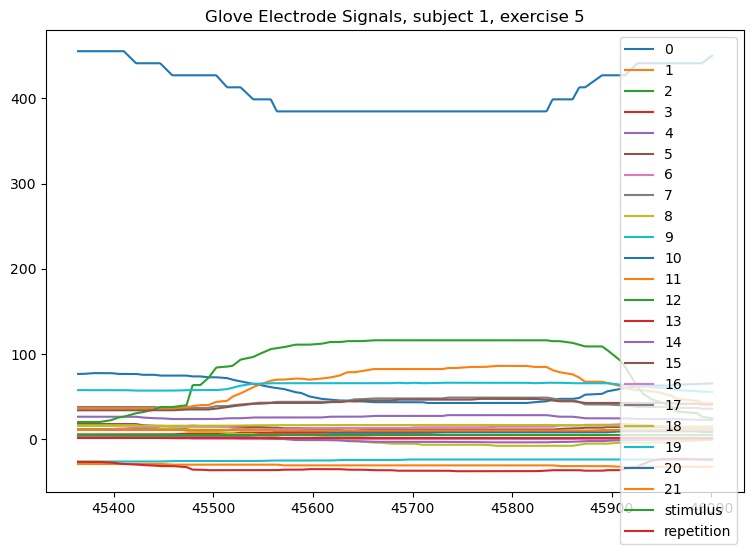

In [19]:
s1_df[(s1_df.stimulus==5) & (s1_df.repetition==2)].plot(figsize=(9,6), title="Glove Electrode Signals, subject 1, exercise 5")

*Using $1$ indexing...*

So, looks like sensors $11$ and $6$ are active in the first exercise (an index finger flexion) and sensors $11$ and $9$ are active in the second exercise (a middle finger flexion). Looking at the image, these make sense.

<img src="sensor_mapping.png" width=300>

In [20]:
repetitions = [1, 2, 3, 4, 5, 6]
stims = [1, 3, 5, 7]
train_windows = []
test_windows = []
for stimulus in stims:
    for repetition in repetitions:
        for subject in range(1, 38):
            dbpth = DB5Path(df[(df.stimulus == stimulus) & (df.repetition == repetition) & (df.subject == subject)], stimulus, repetition, dims = 22)
            if repetition in train_set:
                #train_windows += dbpth.get_windows(window_size=200, overlap=100)
                train_windows += dbpth.downsample(window_size=200)
            elif repetition in test_set:
                test_windows += dbpth.downsample(window_size=200)
                #test_windows += dbpth.get_windows(window_size=200, overlap=100)

In [21]:
train_windows[0]

,index,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,stimulus,repetition
0,0,-1.234766,0.868894,-1.546296,-1.875137,-1.438579,-1.820523,-0.046354,-0.877706,1.634566,...,2.196806,2.420457,3.074958,-0.025747,-0.566038,-3.368841,0.0,1.445385,1,1
1,3,-1.234766,0.868894,-1.546296,-1.875137,-1.438579,-1.820523,-0.046354,-0.877706,1.634566,...,2.196806,2.420457,3.074958,-0.025747,-0.566038,-3.572600,0.0,1.627654,1,1
2,6,-1.234766,0.868894,-1.546296,-1.875137,-1.438579,-1.820523,-0.046354,-0.877706,1.634566,...,2.196806,2.420457,3.074958,-0.025747,-0.566038,-3.776355,0.0,1.809923,1,1
3,9,-1.234766,0.868894,-1.546296,-1.875137,-1.438579,-1.820523,-0.046354,-0.877706,1.634566,...,2.196806,2.420457,3.074958,-0.025747,-0.566038,-3.875775,0.0,1.898858,1,1
4,12,-1.234766,0.868894,-1.546296,-1.875137,-1.438579,-1.820523,-0.046354,-0.877706,1.634566,...,2.196806,2.420457,3.074958,-0.025747,-0.566038,-3.875775,0.0,1.898858,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,585,0.823275,0.361652,0.480947,0.444622,0.897865,0.788392,-0.751150,0.915591,-1.046231,...,-0.946707,0.329396,-0.865654,-1.556534,-0.566038,0.620459,0.0,-0.451344,1,1
196,588,0.887142,0.082048,0.480947,0.444622,0.855108,0.765519,-0.747195,0.816667,-0.913005,...,-0.854389,0.329396,-0.865654,-1.556534,-0.226797,0.620459,0.0,-0.399459,1,1
197,591,0.887142,-0.248586,0.478859,0.444622,0.816646,0.734660,-0.746654,0.698064,-0.755465,...,-0.720322,0.329396,-0.865654,-1.550231,0.262462,0.620459,0.0,-0.399459,1,1
198,594,0.887142,-0.366016,0.372124,0.444622,0.737433,0.666039,-0.718979,0.573425,-0.699513,...,-0.625746,0.329396,-0.865654,-1.227845,0.436235,0.620459,0.0,-0.399459,1,1


In [22]:
axes = [8,10,11,12]
train_x, train_y = splitxy(train_windows, axes, ['stimulus'])
test_x, test_y = splitxy(test_windows, axes, ['stimulus'])

In [23]:
train_x.shape, train_y.shape

((1241, 200, 4), (1241,))

In [24]:
train_signatures = []
for window in tqdm(train_x):
    train_signatures.append(compute_log_signature(window, depth=4))
test_signatures = []
for window in tqdm(test_x):
    test_signatures.append(compute_log_signature(window, depth=4))
train_signatures = np.array(train_signatures)
test_signatures = np.array(test_signatures)

100%|██████████| 609/609 [00:57<00:00, 10.53it/s]


In [25]:
train_signatures.shape, test_signatures.shape

((1241, 90), (609, 90))

svm

In [26]:
from sklearn import svm

In [27]:
classifier = svm.SVC()
classifier.fit(train_signatures, train_y)
print("training set accuracy:", accuracy(classifier.predict(train_signatures), train_y))

training set accuracy: 0.8751007252215954


In [28]:
pred = classifier.predict(test_signatures)
print("testing set accuracy:", accuracy(pred, test_y))

testing set accuracy: 0.7701149425287356


elasticnet

In [29]:
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.preprocessing import OneHotEncoder

In [30]:
encode = OneHotEncoder()
encoded_y = encode.fit_transform(train_y.reshape(-1, 1)).toarray()

In [94]:
elasticnet = MultiTaskElasticNet(alpha=0.05, l1_ratio=1)
elasticnet.fit(train_signatures, encoded_y)

MultiTaskElasticNet(alpha=0.05, l1_ratio=1)

In [95]:
print("training set accuracy elastic: ", accuracy(train_y, np.array(stims)[np.argmax(elasticnet.predict(train_signatures), axis=1)]))

training set accuracy elastic:  0.7123287671232876


In [96]:
task_pred = np.array(stims)[np.argmax(elasticnet.predict(test_signatures), axis=1)]

In [97]:
print("testing set accuracy:", accuracy(task_pred, test_y))

testing set accuracy: 0.6962233169129721


svm confusion matrix

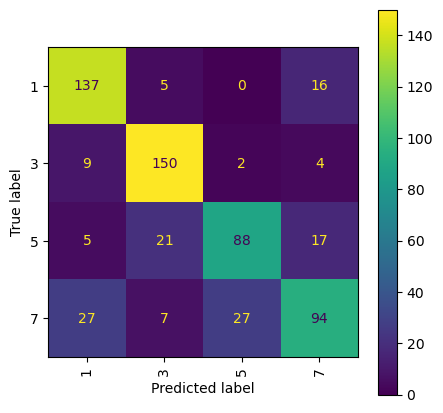

In [45]:
cm = confusion_matrix(test_y, pred)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm, display_labels=stims).plot(ax=ax, xticks_rotation="vertical")

elasticnet confusion matrix

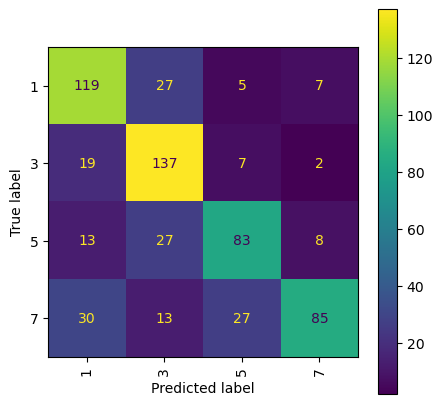

In [98]:
cm = confusion_matrix(test_y, task_pred)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm, display_labels=stims).plot(ax=ax, xticks_rotation="vertical")